In [1284]:
!pip install graphviz

In [1285]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from reader import generic_reader
import seaborn as sns
import os
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
import graphviz

In [1286]:
dataset_danish_actors_bddd = generic_reader.read_csv_file_to_data_frame("../movie_data/danish_actors_movies_2024.csv")
dataset_danish_actors_movies = generic_reader.read_csv_file_to_data_frame("../movie_data/danish_movies_cast_credits.csv")


In [1287]:
list(dataset_danish_actors_movies)

['movie_id', 'actor_id', 'actor_name', 'gender']

In [1288]:
list(dataset_danish_actors_bddd)

['actor_id', 'birthday', 'deathday', 'actor_name']

In [1289]:
columns_to_merge = ["actor_id", "birthday"]

dataset_danish_actors = pd.merge(
    dataset_danish_actors_movies,
    dataset_danish_actors_bddd[columns_to_merge],
    on="actor_id",
    how="left"
)

print(dataset_danish_actors.head())
print(list(dataset_danish_actors))


   movie_id  actor_id         actor_name  gender    birthday
0   1232827   1141086   Vic Carmen Sonne       1  1994-04-23
1   1232827      4460      Trine Dyrholm       1  1972-04-15
2   1232827   1458362       Besir Zeciri       2  1990-07-06
3   1232827   1444187  Joachim Fjelstrup       2  1987-09-25
4   1232827   2263933        Tessa Hoder       1  1997-07-04
['movie_id', 'actor_id', 'actor_name', 'gender', 'birthday']


In [1290]:
print(dataset_danish_actors.describe().round(2))

         movie_id    actor_id   gender
count     4767.00     4767.00  4767.00
mean   1014886.07  2395520.38     0.96
std     252672.68  1579330.12     0.87
min     518245.00       42.00     0.00
25%     809370.00  1260489.00     0.00
50%    1022266.00  2425085.00     1.00
75%    1202178.00  3627427.50     2.00
max    1536970.00  5706467.00     3.00


In [1291]:
dataset_danish_actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4767 entries, 0 to 4766
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movie_id    4767 non-null   int64 
 1   actor_id    4767 non-null   int64 
 2   actor_name  4767 non-null   object
 3   gender      4767 non-null   int64 
 4   birthday    2614 non-null   object
dtypes: int64(3), object(2)
memory usage: 186.3+ KB


In [1292]:
#Add a column with birthyear as an Int to use later
dataset_danish_actors['birthday'] = pd.to_datetime(dataset_danish_actors['birthday'], errors='coerce')
dataset_danish_actors['birthyear'] = dataset_danish_actors['birthday'].dt.year
dataset_danish_actors['birthyear'] = dataset_danish_actors['birthyear'].astype('Int64')

In [1293]:
print(dataset_danish_actors.head())

   movie_id  actor_id         actor_name  gender   birthday  birthyear
0   1232827   1141086   Vic Carmen Sonne       1 1994-04-23       1994
1   1232827      4460      Trine Dyrholm       1 1972-04-15       1972
2   1232827   1458362       Besir Zeciri       2 1990-07-06       1990
3   1232827   1444187  Joachim Fjelstrup       2 1987-09-25       1987
4   1232827   2263933        Tessa Hoder       1 1997-07-04       1997


In [1294]:
dataset_danish_actors.isnull().sum()

movie_id         0
actor_id         0
actor_name       0
gender           0
birthday      2153
birthyear     2153
dtype: int64

In [1295]:
dataset_danish_actors.shape

(4767, 6)

In [1296]:
dataset_danish_actors.describe()

,movie_id,actor_id,gender,birthday,birthyear
count,4.767000e+03,4.767000e+03,4767.000000,2614,2614.0
mean,1.014886e+06,2.395520e+06,0.962450,1977-01-10 13:16:01.285386368,1976.556236
min,5.182450e+05,4.200000e+01,0.000000,1863-05-05 00:00:00,1863.0
25%,8.093700e+05,1.260489e+06,0.000000,1966-03-11 00:00:00,1966.0
50%,1.022266e+06,2.425085e+06,1.000000,1977-11-19 00:00:00,1977.0
75%,1.202178e+06,3.627428e+06,2.000000,1989-11-17 00:00:00,1989.0
max,1.536970e+06,5.706467e+06,3.000000,2025-03-13 00:00:00,2025.0
std,2.526727e+05,1.579330e+06,0.871313,NaN,16.738977


In [1297]:
dataset_danish_actors = dataset_danish_actors.dropna()

In [1298]:
dataset_danish_actors.shape

(2614, 6)

In [1299]:
print(dataset_danish_actors.groupby('gender').size())

gender
0      49
1    1040
2    1522
3       3
dtype: int64


In [1300]:
# Making sure each row have an unique actor/actress
actors_unique = (
    dataset_danish_actors
    .groupby('actor_id', as_index=False)  # ensure actor_id remains a column
    .agg({
        'movie_id': lambda x: set(x),      # collect all movie IDs into a Python set
        'actor_name': 'first',             # name is identical per actor
        'gender': 'first',                 # gender is identical per actor
        'birthday': 'first',               # birthday is identical per actor
        'birthyear': 'first'               # birthyear is identical per actor
    })
)


actors_unique['num_movies'] = actors_unique['movie_id'].apply(len)


dataset_danish_actors = actors_unique

print(len(dataset_danish_actors))        


1240


In [1301]:
dataset_danish_actors.shape

(1240, 7)

In [1302]:
print(dataset_danish_actors.groupby('gender').size())

gender
0     23
1    498
2    717
3      2
dtype: int64


In [1303]:
dataset_danish_actors.isnull().sum()

actor_id      0
movie_id      0
actor_name    0
gender        0
birthday      0
birthyear     0
num_movies    0
dtype: int64

In [1304]:
dataset_danish_actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   actor_id    1240 non-null   int64         
 1   movie_id    1240 non-null   object        
 2   actor_name  1240 non-null   object        
 3   gender      1240 non-null   int64         
 4   birthday    1240 non-null   datetime64[ns]
 5   birthyear   1240 non-null   Int64         
 6   num_movies  1240 non-null   int64         
dtypes: Int64(1), datetime64[ns](1), int64(3), object(2)
memory usage: 69.2+ KB


In [1305]:
feature_cols = ["birthyear", "num_movies"]  # exclude gender
X = dataset_danish_actors[feature_cols].values
y = dataset_danish_actors["gender"].values

In [1306]:
#Since low data sample of unkown and non-binary (23 and 2) won't they be included
Female = np.array(X[y==1])
Male = np.array(X[y==2])

In [1307]:
set_prop = 0.20

In [1308]:
seed = 12

In [1309]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [1310]:
params = {'max_depth': 5}
classifier = DecisionTreeClassifier(**params)
#classifier = RandomForestClassifier(n_estimators = 100, max_depth = 4)

In [1311]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [1312]:
#dot_data = tree.export_graphviz(classifier, out_file=None, 
                        # feature_names=dataset_danish_actors.columns[:2], class_names = True,        
                        # filled=True, rounded=True, proportion = False,
                        # special_characters=True)   

In [1313]:
graph = graphviz.Source(dot_data)
graph.render("heart")

'heart.pdf'

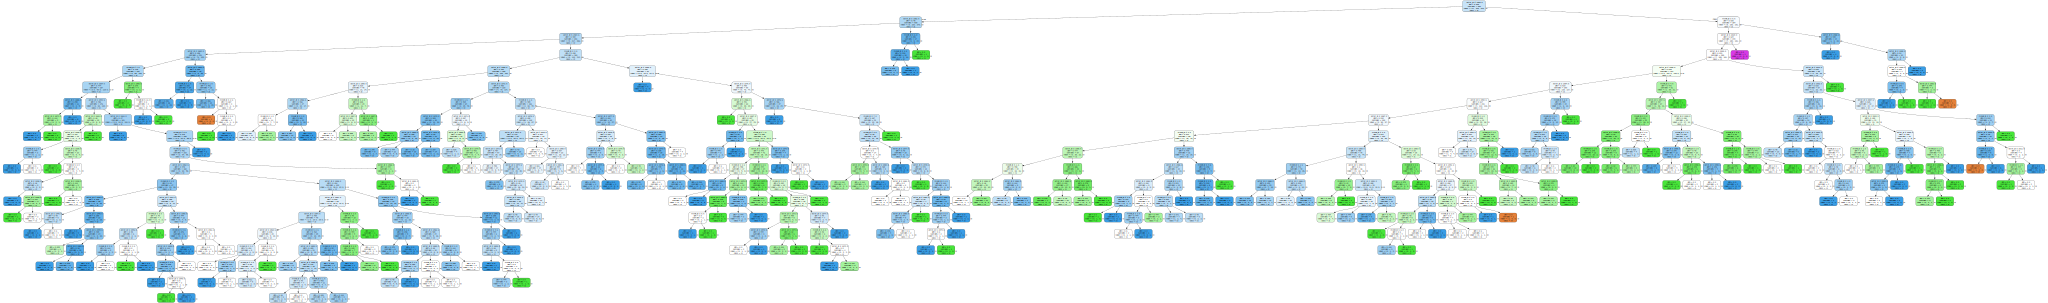

In [1314]:
graph

In [1315]:
scoring = 'accuracy'

In [1316]:
y_testp = classifier.predict(X_test)
y_testp

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

In [1317]:
y_test

array([2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2,
       1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1,
       1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 1])

In [1318]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.6088709677419355


In [1319]:
confusion_mat = confusion_matrix(y_test,y_testp)
confusion_mat

array([[  0,   1,   5],
       [  0,  11,  84],
       [  0,   7, 140]])

In [1320]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,1,2
row_0,,
0,1,5
1,11,84
2,7,140


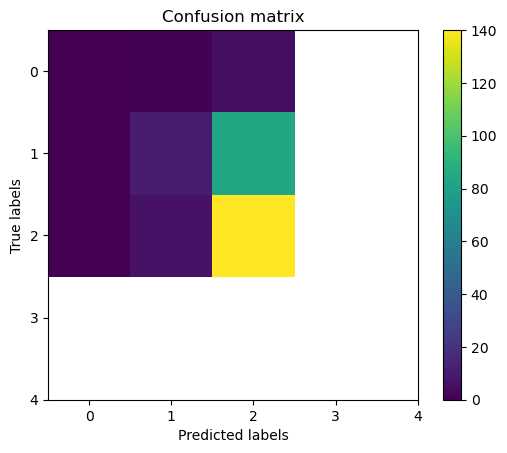

In [1321]:
plt.imshow(confusion_mat, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

<Axes: >

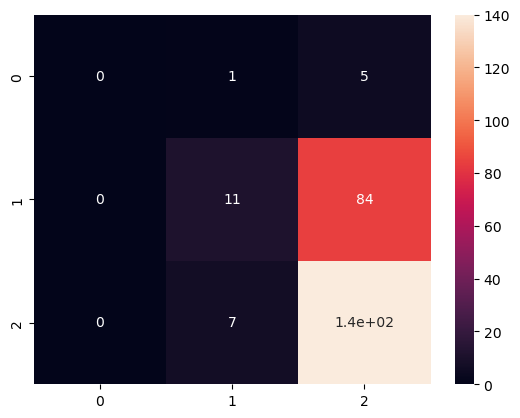

In [1322]:
sns.heatmap(confusion_mat, annot=True)